In [1]:
import sys
import os
import time
import string
import random
import collections
import cPickle as pickle
import gzip
import ast

import numpy as np
import theano
import theano.tensor as T
import lasagne
import h5py

from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.layers import PadLayer
from lasagne.layers import ExpressionLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import FlattenLayer
from lasagne.layers import ReshapeLayer
from lasagne.layers import ConcatLayer
from lasagne.layers import SliceLayer
from lasagne.layers import DropoutLayer
from lasagne.nonlinearities import softmax, rectify, elu, sigmoid, tanh, softplus
from lasagne.layers import batch_norm, BatchNormLayer

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils import *
from layers import *
from model import Network, CocoData

In [2]:
REPO_DIR = '../'
STYLE_LOSS_LAYERS = {'conv1_2': 1e-4,'conv2_2': 1e-4,'conv3_3': 1e-4,'conv4_3': 1e-4}
CONTENT_LOSS_LAYER = 'conv3_3'
NUM_EPOCHS = 8 # 40k steps is around 8 epochs
STYLE_IMAGE_LOCATION = REPO_DIR + 'data/images/styles/candy.jpg'

In [3]:
image_var = T.tensor4('inputs')
pastiche_content_var = T.tensor4('pastiche_content')
style_var = T.TensorType(theano.config.floatX,(False,)*5) ('style')
pastiche_style_var = T.TensorType(theano.config.floatX,(False,)*5) ('pastiche_style')

net = Network(image_var)
data = CocoData('../data/images/content/ms-coco-256-sample.h5')

In [4]:
# initialize transformer network function
transform_pastiche_out = lasagne.layers.get_output(net.network['transform_net'])
pastiche_transform_fn = theano.function([image_var], transform_pastiche_out)

# initialize loss network related functions
# if content_loss_layer in style_loss_layers.keys():
#     vgg_all_out = lasagne.layers.get_output([net.network['loss_net'][x] for x in style_loss_layers.keys()])
# else:
#     vgg_all_out = lasagne.layers.get_output([net.network['loss_net'][x] for x in style_loss_layers.keys()+[content_loss_layer]])
# vgg_style_out = lasagne.layers.get_output([net.network['loss_net'][x] for x in style_loss_layers.keys()])
# vgg_content_out = lasagne.layers.get_output(net.network['loss_net'][content_loss_layer])

# style_image_vgg_fn = theano.function([image_var], vgg_style_out)
# content_image_vgg_fn = theano.function([image_var], vgg_content_out)
# pastiche_vgg_fn = theano.function([image_var], vgg_all_out)

style_loss_layer_keys = STYLE_LOSS_LAYERS.keys()
style_loss_layer_weights = [STYLE_LOSS_LAYERS[w] for w in style_loss_layer_keys]

if CONTENT_LOSS_LAYER in style_loss_layer_keys:
    vgg_all_out = lasagne.layers.get_output([net.network['loss_net'][x] for x in style_loss_layer_keys], transform_pastiche_out)
    vgg_pastiche_style_out = vgg_all_out
    vgg_pastiche_content_out = vgg_all_out[style_loss_layer_keys.index(CONTENT_LOSS_LAYER)]
else:
    vgg_all_out = lasagne.layers.get_output([net.network['loss_net'][x] for x in style_loss_layer_keys+[CONTENT_LOSS_LAYER]], transform_pastiche_out)
    vgg_pastiche_style_out = vgg_all_out[:-1]
    vgg_pastiche_content_out = vgg_all_out[-1]
vgg_style_out = lasagne.layers.get_output([net.network['loss_net'][x] for x in style_loss_layer_keys], image_var)
vgg_content_out = lasagne.layers.get_output(net.network['loss_net'][CONTENT_LOSS_LAYER], image_var)

style_image_vgg_fn = theano.function([image_var], vgg_style_out)
content_image_vgg_fn = theano.function([image_var], vgg_content_out)

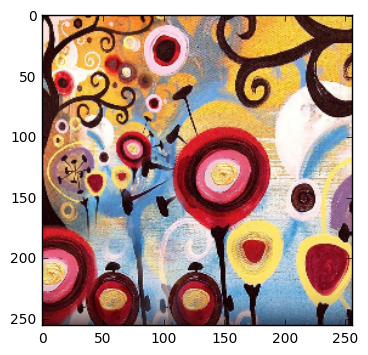

In [5]:
style_im = np.expand_dims(get_image(STYLE_IMAGE_LOCATION, (256, 256)), 0)
plt.imshow(style_im[0].transpose((1,2,0)))

In [6]:
vgg_style_values = style_image_vgg_fn(style_im)
print len(vgg_style_values)
print vgg_style_values[0].shape

4
(1, 256, 64, 64)


In [7]:
import h5py

dataset = h5py.File("../data/images/content/ms-coco-256-sample.h5", "r")

(40, 3, 256, 256)


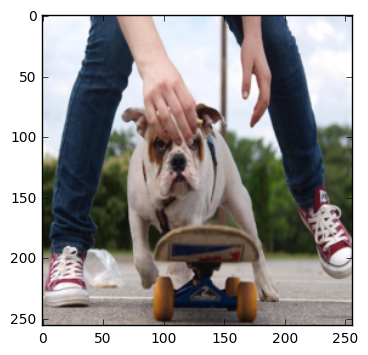

In [8]:
print dataset['train2014']['images'].shape
plt.figure()
plt.imshow(dataset['train2014']['images'][0].transpose((1,2,0)))

In [9]:
# style_loss_layer_keys = STYLE_LOSS_LAYERS.keys()
# style_loss_layer_weights = [STYLE_LOSS_LAYERS[w] for w in style_loss_layer_keys]

# loss = net.feature_loss(pastiche_content_var, image_var)
# loss += T.sum(net.style_loss(pastiche_style_var, style_var)*style_loss_layer_weights)

# params = lasagne.layers.get_all_params(net.network['transform_net'], trainable=True)
# updates = lasagne.updates.adam(loss, params)
# train_fn = theano.function([pastiche_content_var, pastiche_style_var, image_var, style_var], loss, updates=updates)
# # TODO: If using conditional instance norm, make this deterministic
# valid_fn = theano.function([pastiche_content_var, pastiche_style_var, image_var, style_var], loss)

loss = net.feature_loss(vgg_pastiche_content_out, vgg_content_out)
for pso, vsv, sllw in zip(vgg_pastiche_style_out, vgg_style_values, style_loss_layer_weights):
    loss += net.style_loss(pso, theano.shared(vsv))*sllw

params = lasagne.layers.get_all_params(net.network['transform_net'], trainable=True)
updates = lasagne.updates.adam(loss, params)
train_fn = theano.function([image_var], loss, updates=updates)
# TODO: If using conditional instance norm, make this deterministic
valid_fn = theano.function([image_var], loss)

In [10]:
for v in vgg_style_values:
    print v.shape

(1, 256, 64, 64)
(1, 64, 256, 256)
(1, 128, 128, 128)
(1, 512, 32, 32)


In [ ]:
NUM_EPOCHS = 2
for epoch in range(NUM_EPOCHS):
    train_err = 0
    valid_err = 0
    train_batch_num = 0
    valid_batch_num = 0
    start_time = time.time()

    for content_ims in data.get_train_batch():
        if not train_batch_num:
            plt.figure()
            plt.imshow(dataset['train2014']['images'][0].transpose((1,2,0)))
            plt.figure()
            plt.imshow(pastiche_transform_fn(dataset['train2014']['images'][0:1])[0].transpose((1,2,0)))
        train_err += train_fn(content_ims)
        train_batch_num += 1

    for content_ims in data.get_valid_batch():
        valid_err += valid_fn(content_ims)
        valid_batch_num += 1

        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, NUM_EPOCHS, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batch_num))
        print("  valid loss:\t\t{:.6f}".format(valid_err / valid_batch_num))